In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [3]:
# 셀에서 값을 모두 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [4]:
## 설정
# 지수표기법 대신 숫자표기법
pd.options.display.float_format = '{:.2f}'.format

# 스타일
plt.style.use('seaborn-v0_8-darkgrid')

# 폰트
from matplotlib import font_manager
font_path = "C:/Users/sangw/AppData/Local/Microsoft/Windows/Fonts/NanumSquareR.ttf"
font_manager.fontManager.addfont(font_path)
plt.rc('font', family='NanumSquare') # 한글 폰트 지정

# 데이터 프레임의 모든 레코드 출력
def print_all(obj, n=None):
    pd.set_option('display.max_row', n)
    display(obj)
    pd.set_option('display.max_row', 10)

# 모든 칼럼 출력
pd.set_option('display.max_columns', None)

# 데이터 로드 및 탐색

## 데이터 로드

In [5]:
# 데이터세트 다운로드
path = kagglehub.dataset_download('vasudeva009/predicting-coupon-redemption')

In [6]:
# 데이터세트 로드
campaign_data = pd.read_csv(f"{path}/campaign_data.csv")
coupon_item_mapping = pd.read_csv(f"{path}/coupon_item_mapping.csv")
customer_demographics = pd.read_csv(f"{path}/customer_demographics.csv")
customer_transaction_data = pd.read_csv(f"{path}/customer_transaction_data.csv")
item_data = pd.read_csv(f"{path}/item_data.csv")
train_data = pd.read_csv(f"{path}/train.csv")

## 데이터 기초 탐색

In [15]:
# 데이터 탐색 코드
def summary_df(df):
  summary = {
      '변수명':[],
      '데이터 타입':[],
      '결측치 개수':[],
      '유니크 데이터 수':[],
      '첫 번째 레코드 값':[],
      '두 번째 레코드 값':[]
  }

  for col in df.columns:
    summary['변수명'].append(col)
    summary['데이터 타입'].append(df[col].dtype)
    summary['결측치 개수'].append(df[col].isna().sum())
    summary['유니크 데이터 수'].append(df[col].nunique())
    summary['첫 번째 레코드 값'].append(df[col].iloc[0] if len(df) > 0 else None)
    summary['두 번째 레코드 값'].append(df[col].iloc[1] if len(df) > 1 else None)

  summary_df = pd.DataFrame(summary)
  return summary_df

In [19]:
# 데이터 탐색: train_data
train_data.head()
summary_df(train_data)
train_data.shape

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,id,int64,0,78369,1,2
1,campaign_id,int64,0,18,13,13
2,coupon_id,int64,0,866,27,116
3,customer_id,int64,0,1428,1053,48
4,redemption_status,int64,0,2,0,0


(78369, 5)

In [20]:
# 데이터 탐색: campaign_data
campaign_data.head()
summary_df(campaign_data)
campaign_data.shape

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,campaign_id,int64,0,28,24,25
1,campaign_type,object,0,2,Y,Y
2,start_date,object,0,25,21/10/13,21/10/13
3,end_date,object,0,26,20/12/13,22/11/13


(28, 4)

In [21]:
# 데이터 탐색: coupon_item_mapping
coupon_item_mapping.head()
summary_df(coupon_item_mapping)
coupon_item_mapping.shape

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,coupon_id,int64,0,1116,105,107
1,item_id,int64,0,36289,37,75


(92663, 2)

In [22]:
# 데이터 탐색: customer_demographics
customer_demographics.head()
summary_df(customer_demographics)
customer_demographics.shape

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,customer_id,int64,0,760,1,6
1,age_range,object,0,6,70+,46-55
2,marital_status,object,329,2,Married,Married
3,rented,int64,0,2,0,0
4,family_size,object,0,5,2,2
5,no_of_children,object,538,3,NaN,NaN
6,income_bracket,int64,0,12,4,5


(760, 7)

- marital_status의 결측비율은 약 43%로 모델링에서 해당 변수 제외 예정
- no_of_children의 결측비율은 약 71%로 모델링에서 해당 변수 제외 예정

In [23]:
# 데이터 탐색: customer_transaction_data
customer_transaction_data.head()
summary_df(customer_transaction_data)
customer_transaction_data.shape

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,date,object,0,549,2012-01-02,2012-01-02
1,customer_id,int64,0,1582,1501,1501
2,item_id,int64,0,74063,26830,54253
3,quantity,int64,0,9252,1,1
4,selling_price,float64,0,4923,35.26,53.43
5,other_discount,float64,0,1418,-10.69,-13.89
6,coupon_discount,float64,0,232,0.0,0.0


(1324566, 7)

In [24]:
# 데이터 탐색: item_data
item_data.head()
summary_df(item_data)
item_data.shape

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


,변수명,데이터 타입,결측치 개수,유니크 데이터 수,첫 번째 레코드 값,두 번째 레코드 값
0,item_id,int64,0,74066,1,2
1,brand,int64,0,5528,1,1
2,brand_type,object,0,2,Established,Established
3,category,object,0,19,Grocery,Miscellaneous


(74066, 4)

## 데이터 전처리

In [7]:
# 날짜 관련 칼럼 datatime 형식 변환
campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], format='%d/%m/%y')
campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], format='%d/%m/%y')
customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'])

# 헷갈리지 않게 칼럼명 변경
customer_transaction_data = customer_transaction_data.rename(columns={'date':'transaction_date'})

In [8]:
# 중복 데이터 탐색
"""
train_data[train_data.duplicated(keep=False)]
campaign_data[campaign_data.duplicated(keep=False)]
coupon_item_mapping[coupon_item_mapping.duplicated(keep=False)]
customer_demographics[customer_demographics.duplicated(keep=False)]
item_data[item_data.duplicated(keep=False)]
customer_transaction_data[customer_transaction_data.duplicated(keep=False)]
"""

# 중복 데이터 제거(2,916건)
customer_transaction_data = customer_transaction_data.drop_duplicates()

'\ntrain_data[train_data.duplicated(keep=False)]\ncampaign_data[campaign_data.duplicated(keep=False)]\ncoupon_item_mapping[coupon_item_mapping.duplicated(keep=False)]\ncustomer_demographics[customer_demographics.duplicated(keep=False)]\nitem_data[item_data.duplicated(keep=False)]\ncustomer_transaction_data[customer_transaction_data.duplicated(keep=False)]\n'

# 데이터 분석

## 1) 쿠폰 사용 패턴 분석

### 데이터 준비

In [70]:
# 분석에 필요한 변수만 추출하여 데이터 병합
# 1. 데이터 병합 (train + customer_demographics + campaign_data)
# 'customer_id'와 'campaign_id'를 기준으로 병합
coupon_pattern = (
    train_data
    .merge(customer_demographics, on='customer_id', how='left')
    .merge(campaign_data, on='campaign_id', how='left')
)

# 2. 필요한 변수 추출
# 분석에 필요한 변수만 선택
coupon_pattern = coupon_pattern[[
    'redemption_status', 'age_range', 'marital_status', 'rented', 
    'family_size', 'no_of_children', 'income_bracket', 'campaign_type'
]]

### 데이터 분석

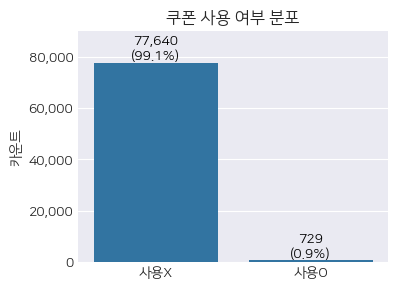

In [96]:
# 쿠폰 사용 여부 분포 시각화
_ = plt.figure(figsize=(4, 3))
ax = sns.countplot(data=coupon_pattern, x='redemption_status')
_ = plt.title("쿠폰 사용 여부 분포")
_ = plt.xticks([0, 1], ['사용X', '사용O'])
_ = plt.ylim(0, 90000)
_ = plt.ylabel("카운트")
_ = plt.xlabel("")

# y축 값에 쉼표 추가 포맷 설정
_ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# 각 바 위에 실제 값 표시
# 총 카운트 계산
total_count = coupon_pattern['redemption_status'].value_counts().sum()

for p in ax.patches:
    count = int(p.get_height())  # 카운트 값
    percentage = count / total_count * 100  # 비율 계산
    formatted_count = f"{count:,}"  # 1000 단위로 쉼표 추가
    formatted_percentage = f"{percentage:.1f}%"  # 소수 첫째 자리까지 비율 표시

    # 텍스트 추가 (카운트와 비율 표시)
    _ = ax.annotate(f'{formatted_count}\n({formatted_percentage})',
                (p.get_x() + p.get_width() / 2., p.get_height()),  # 텍스트 위치 (x, y)
                ha='center', va='center', fontsize=10, color='black',  # 폰트 사이즈 5로 설정
                xytext=(0, 10), textcoords='offset points')  # 텍스트 오프셋 (바 위로 5포인트 위)
_ = plt.show()

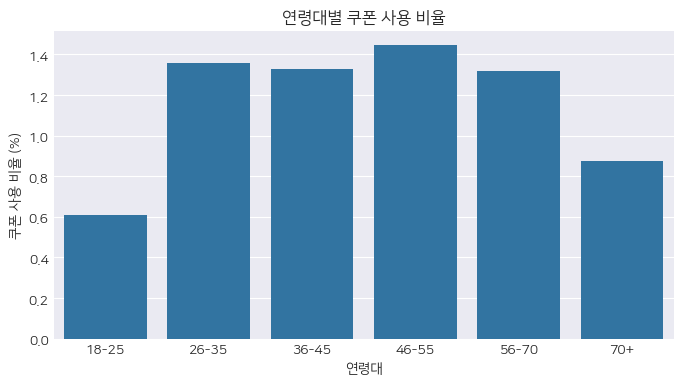

In [126]:
# (1) 연령대(age_range)별 쿠폰 사용 비율
age_redemption = (
    coupon_pattern.groupby('age_range')['redemption_status']
    .mean()
    .reset_index()
)
# 비율을 100으로 변환
age_redemption['redemption_status'] = age_redemption['redemption_status'] * 100

# 전체 평균 비율 계산
overall_average = coupon_pattern['redemption_status'].mean() * 100

_ = plt.figure(figsize=(8, 4))
_ = sns.barplot(data=age_redemption, x='age_range', y='redemption_status')
_ = plt.title("연령대별 쿠폰 사용 비율")
_ = plt.ylabel("쿠폰 사용 비율 (%)")
_ = plt.xlabel("연령대")

_ = plt.show()

In [149]:
# 카이제곱 검정 수행: 연령대와 쿠폰 사용 여부의 관계 통계적 검증

# 교차표 생성
age_contingency_tb = pd.crosstab(coupon_pattern['age_range'], coupon_pattern['redemption_status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(age_contingency_tb)

# 결과 테이블 생성
age_chi2_results = pd.DataFrame({
    "Statistic": ["Chi2", "p-value", "Degrees of Freedom"],
    "Value": [chi2, p, dof]
})


# 기대 빈도 테이블 생성
age_combined_table = age_contingency_tb.copy()
age_combined_table.columns = [f"실제_{col}" for col in age_combined_table.columns]

age_expected_df = pd.DataFrame(expected, 
                           index=age_contingency_tb.index, 
                           columns=[f"기대빈도_{col}" for col in age_contingency_tb.columns])

# 실제값 + 기대빈도 테이블 결합
age_combined_table = pd.concat([age_combined_table, age_expected_df], axis=1)

age_contingency_tb
age_chi2_results
age_combined_table

redemption_status,0,1
age_range,,
18-25,2441,15
26-35,7915,109
36-45,11061,149
46-55,14935,219
56-70,3674,49
70+,3067,27


,Statistic,Value
0,Chi2,16.269269
1,p-value,0.006116
2,Degrees of Freedom,5.000000


,실제_0,실제_1,기대빈도_0,기대빈도_1
age_range,,,,
18-25,2441,15,2424.049106,31.950894
26-35,7915,109,7919.613202,104.386798
36-45,11061,149,11064.165502,145.834498
46-55,14935,219,14956.856737,197.143263
56-70,3674,49,3674.566295,48.433705
70+,3067,27,3053.749158,40.250842


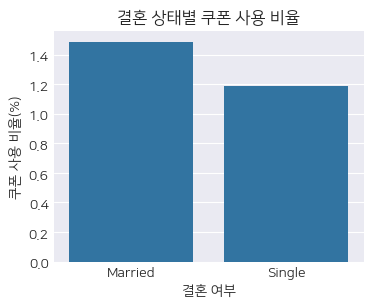

In [128]:
# (2) 결혼 여부(marital_status)와 쿠폰 사용
marital_redemption = (
    coupon_pattern.groupby('marital_status')['redemption_status']
    .mean()
    .reset_index()
)
# 비율을 100으로 변환
marital_redemption['redemption_status'] = marital_redemption['redemption_status'] * 100

_ = plt.figure(figsize=(4, 3))
_ = sns.barplot(data=marital_redemption, x='marital_status', y='redemption_status')
_ = plt.title("결혼 상태별 쿠폰 사용 비율")
_ = plt.ylabel("쿠폰 사용 비율(%)")
_ = plt.xlabel("결혼 여부")
_ = plt.show()

In [150]:
# 카이제곱 검정 수행: 연령대와 쿠폰 사용 여부의 관계 통계적 검증

# 교차표 생성
marital_contingency_tb = pd.crosstab(coupon_pattern['marital_status'], coupon_pattern['redemption_status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(marital_contingency_tb)

# 결과 테이블 생성
marital_chi2_results = pd.DataFrame({
    "Statistic": ["Chi2", "p-value", "Degrees of Freedom"],
    "Value": [chi2, p, dof]
})


# 기대 빈도 테이블 생성
marital_combined_table = marital_contingency_tb.copy()
marital_combined_table.columns = [f"실제_{col}" for col in marital_combined_table.columns]

marital_expected_df = pd.DataFrame(expected, 
                           index=marital_contingency_tb.index, 
                           columns=[f"기대빈도_{col}" for col in marital_contingency_tb.columns])

# 실제값 + 기대빈도 테이블 결합
marital_combined_table = pd.concat([marital_combined_table, marital_expected_df], axis=1)

marital_contingency_tb
marital_chi2_results
marital_combined_table

redemption_status,0,1
marital_status,,
Married,18531,280
Single,6505,78


,Statistic,Value
0,Chi2,3.019551
1,p-value,0.082266
2,Degrees of Freedom,1.000000


,실제_0,실제_1,기대빈도_0,기대빈도_1
marital_status,,,,
Married,18531,280,18545.805938,265.194062
Single,6505,78,6490.194062,92.805938


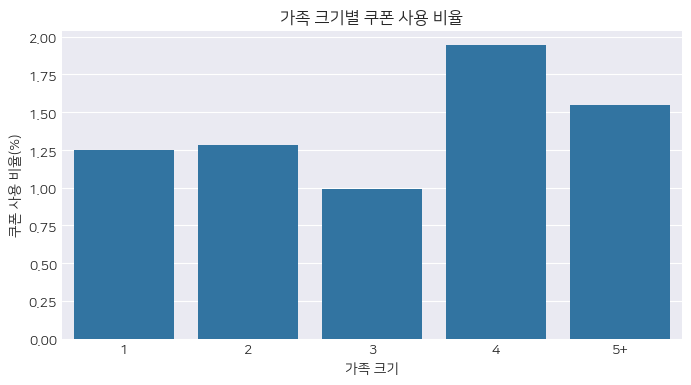

In [132]:
# (3) 가족 크기(family_size)와 쿠폰 사용 비율
family_redemption = (
    coupon_pattern.groupby('family_size')['redemption_status']
    .mean()
    .reset_index()
)
# 비율을 100으로 변환
family_redemption['redemption_status'] = family_redemption['redemption_status'] * 100

_ = plt.figure(figsize=(8, 4))
_ = sns.barplot(data=family_redemption, x='family_size', y='redemption_status')
_ = plt.title("가족 크기별 쿠폰 사용 비율")
_ = plt.ylabel("쿠폰 사용 비율(%)")
_ = plt.xlabel("가족 크기")
_ = plt.show()

In [151]:
# 카이제곱 검정 수행: 연령대와 쿠폰 사용 여부의 관계 통계적 검증

# 교차표 생성
family_size_contingency_tb = pd.crosstab(coupon_pattern['family_size'], coupon_pattern['redemption_status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(family_size_contingency_tb)

# 결과 테이블 생성
family_size_chi2_results = pd.DataFrame({
    "Statistic": ["Chi2", "p-value", "Degrees of Freedom"],
    "Value": [chi2, p, dof]
})


# 기대 빈도 테이블 생성
family_size_combined_table = family_size_contingency_tb.copy()
family_size_combined_table.columns = [f"실제_{col}" for col in family_size_combined_table.columns]

family_size_expected_df = pd.DataFrame(expected, 
                           index=family_size_contingency_tb.index, 
                           columns=[f"기대빈도_{col}" for col in family_size_contingency_tb.columns])

# 실제값 + 기대빈도 테이블 결합
family_size_combined_table = pd.concat([family_size_combined_table, family_size_expected_df], axis=1)

family_size_contingency_tb
family_size_chi2_results
family_size_combined_table

redemption_status,0,1
family_size,,
1,13442,170
2,16671,217
3,6205,62
4,3078,61
5+,3697,58


,Statistic,Value
0,Chi2,16.884339
1,p-value,0.002036
2,Degrees of Freedom,4.000000


,실제_0,실제_1,기대빈도_0,기대빈도_1
family_size,,,,
1,13442,170,13434.917111,177.082889
2,16671,217,16668.298573,219.701427
3,6205,62,6185.470580,81.529420
4,3078,61,3098.163739,40.836261
5+,3697,58,3706.149997,48.850003


## 2) 할인 쿠폰 사용이 고객 행동에 미치는 영향 분석

### 데이터 준비

In [15]:
# 1. 분석 대상자 선정: 첫 거래 시점과 첫 할인 쿠폰 사용 시점의 차이가 2개월 이상 나는 고객
# 분석 목표: 첫 할인 쿠폰 사용 시점을 기준으로 이전 2개월과 이후 2개월간 고객별 총 매출출 금액 및 평균 구매 빈도를 비교하여 할인 쿠폰 프로모션의 효과를 분석

# 전체 거래된 데이터에 대하여 쿠폰 사용 여부 확인
customer_transaction_data['coupon_yn'] = np.where(customer_transaction_data['coupon_discount'] == 0, 0, 1)

# 분석 대상자 선정
used_coupon = customer_transaction_data.groupby(['customer_id', 'coupon_yn'], as_index=False)['transaction_date'].min()\
    .pivot(index='customer_id', columns='coupon_yn', values='transaction_date').reset_index()

used_coupon['date_diff'] = (used_coupon[1] - used_coupon[0]).dt.days
filtered_customers = used_coupon[used_coupon['date_diff'] >= 60]['customer_id']

In [16]:
# 고객별 첫 쿠폰 사용 시점 가져오기
filtered_transactions = customer_transaction_data[customer_transaction_data['customer_id'].isin(filtered_customers)].copy()
filtered_transactions = filtered_transactions.merge(used_coupon[['customer_id', 1]].rename(columns={1:'first_coupon_date'}), on='customer_id')

# 첫 쿠폰 사용일 기준으로 전후 2개월 데이터 필터링
filtered_transactions['days_from_coupon'] = (filtered_transactions['transaction_date'] - filtered_transactions['first_coupon_date']).dt.days
analysis_data = filtered_transactions[(filtered_transactions['days_from_coupon'] >= -60) & (filtered_transactions['days_from_coupon'] <= 60)]


In [17]:
# 전/후 구분
analysis_data['period'] = np.where(analysis_data['days_from_coupon'] <0, 'pre', 'post')

# 총 매출 금액 및 구매 빈도 집계
analysis_agg = analysis_data.groupby(['customer_id', 'period'])\
    .agg(
        total_revenue = ('selling_price', 'sum'),
        purchase_cnt = ('transaction_date', 'count')
    ).reset_index()

# 비교 분석을 위한 데이터 변환
analysis_comparison_df = analysis_agg.pivot(index='customer_id', columns='period', values=['total_revenue', 'purchase_cnt'])
analysis_comparison_df.columns = ['post_total_revenue', 'pre_total_revenue', 'post_purchase_cnt', 'pre_purchase_cnt']
analysis_comparison_df = analysis_comparison_df.reset_index()

analysis_comparison_df


C:\Users\sangw\AppData\Local\Temp\ipykernel_34116\1449621648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['period'] = np.where(analysis_data['days_from_coupon'] <0, 'pre', 'post')


,customer_id,post_total_revenue,pre_total_revenue,post_purchase_cnt,pre_purchase_cnt
0,3,23566.77,14939.75,206.00,161.00
1,5,15975.81,12725.49,132.00,116.00
2,6,4408.31,10165.91,35.00,93.00
3,7,15788.89,8711.20,157.00,86.00
4,9,8849.43,1096.40,76.00,16.00
...,...,...,...,...,...
729,1570,34256.62,16527.51,240.00,152.00
730,1572,4564.35,249.34,56.00,2.00
731,1574,27374.60,5428.48,254.00,36.00
732,1575,6263.42,4069.91,69.00,48.00


### 데이터 분석

In [29]:
# 1. 총 매출 변화 분석
## 0) 결측치 제거
total_revenue_df = analysis_comparison_df.dropna(subset=['pre_total_revenue', 'post_total_revenue'])

## 1) 정규성 검정
from scipy.stats import shapiro
revenue_diff = total_revenue_df['post_total_revenue'] - total_revenue_df['pre_total_revenue']
stat, p_value = shapiro(revenue_diff)

print(f"Shapiro-Wilk Test: stat={stat}, p-value={p_value}")

if p_value < 0.05:
    print("데이터가 정규성을 만족하지 않음 (Wilcoxon Test 사용)")
else:
    print("데이터가 정규성을 만족함 (T-Test 사용 가능)")

print('\n------------------------------\n')

## 2) T-검정
from scipy.stats import ttest_rel, wilcoxon

# 구매 금액 변화에 대한 T-검정
t_stat_revenue, p_value_revenue = ttest_rel(total_revenue_df['pre_total_revenue'], total_revenue_df['post_total_revenue'])
print(f"T-test 결과: t-stat={t_stat_revenue}, p-value={p_value_revenue}")

# 비모수 검정 (Wilcoxon)
w_stat_revenue, p_value_w_revenue = wilcoxon(total_revenue_df['pre_total_revenue'], total_revenue_df['post_total_revenue'])
print(f"Wilcoxon Test 결과: w-stat={w_stat_revenue}, p-value={p_value_w_revenue}")


Shapiro-Wilk Test: stat=0.9400489330291748, p-value=1.5195583138306976e-16
데이터가 정규성을 만족하지 않음 (Wilcoxon Test 사용)

------------------------------

T-test 결과: t-stat=-13.252254822521872, p-value=4.6277288854966404e-36
Wilcoxon Test 결과: w-stat=59535.0, p-value=5.394989939558909e-38


할인 쿠폰 사용 전 평균 매출액: 11030.341758241759
할인 쿠폰 사용 후 평균 매출액: 14861.92282967033

------------------------------



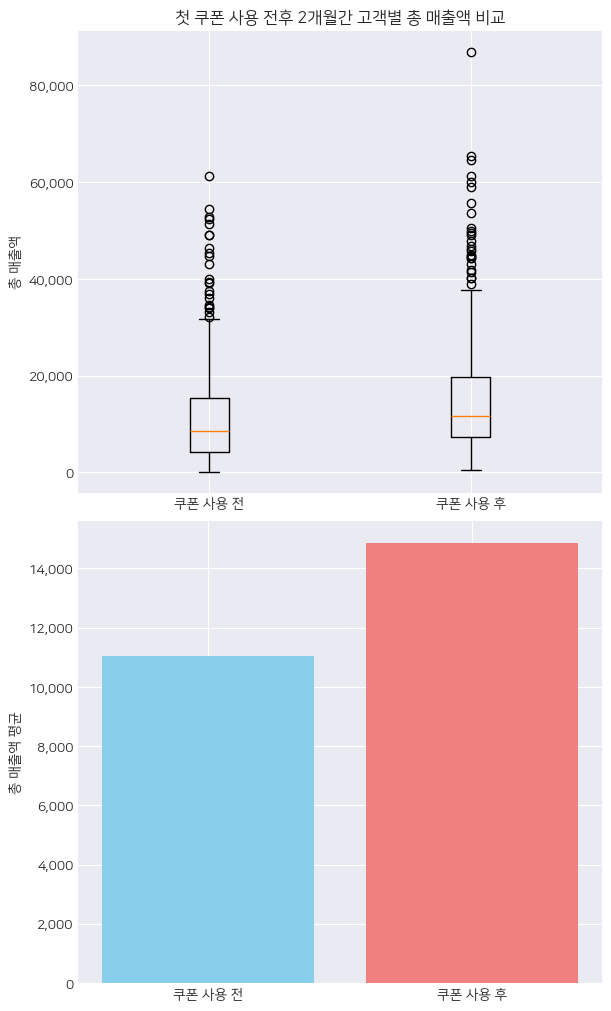

In [ ]:
## 3) 시각화
# 평균 매출 계산
pre_avg = total_revenue_df['pre_total_revenue'].mean()
post_avg = total_revenue_df['post_total_revenue'].mean()

print(f'할인 쿠폰 사용 전 평균 매출액: {pre_avg}')
print(f'할인 쿠폰 사용 후 평균 매출액: {post_avg}')
print('\n------------------------------\n')

# 서브플롯 생성 (박스플롯 + 막대그래프)
fig, axes = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

# 1. 박스플롯
_ = axes[0].boxplot(
    [total_revenue_df['pre_total_revenue'], total_revenue_df['post_total_revenue']],
    labels=['쿠폰 사용 전', '쿠폰 사용 후']
)
_ = axes[0].set_title("첫 쿠폰 사용 전후 2개월간 고객별 총 매출액 비교")
_ = axes[0].set_ylabel("총 매출액")
_ = axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# 2. 막대그래프
_ = axes[1].bar(['쿠폰 사용 전', '쿠폰 사용 후'], [pre_avg, post_avg], color=['skyblue', 'lightcoral'])
_ = axes[1].set_title("")
_ = axes[1].set_ylabel("총 매출액 평균")
_ = axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# 그래프 표시
plt.show()

In [35]:
# 1. 구매 빈도 변화화 분석
## 0) 결측치 제거
purchase_cnt_df = analysis_comparison_df.dropna(subset=['pre_purchase_cnt', 'post_purchase_cnt'])

## 1) 정규성 검정
from scipy.stats import shapiro
purchase_diff = purchase_cnt_df['post_purchase_cnt'] - purchase_cnt_df['pre_purchase_cnt']
stat, p_value = shapiro(purchase_diff)

print(f"Shapiro-Wilk Test: stat={stat}, p-value={p_value}")

if p_value < 0.05:
    print("데이터가 정규성을 만족하지 않음 (Wilcoxon Test 사용)")
else:
    print("데이터가 정규성을 만족함 (T-Test 사용 가능)")

print('\n------------------------------\n')

## 2) T-검정
from scipy.stats import ttest_rel, wilcoxon

# 구매 금액 변화에 대한 T-검정
t_stat_purchase, p_value_purchase = ttest_rel(purchase_cnt_df['pre_purchase_cnt'], purchase_cnt_df['post_purchase_cnt'])
print(f"T-test 결과: t-stat={t_stat_purchase}, p-value={p_value_purchase}")

# 비모수 검정 (Wilcoxon)
w_stat_purchase, p_value_w_purchase = wilcoxon(purchase_cnt_df['pre_purchase_cnt'], purchase_cnt_df['post_purchase_cnt'])
print(f"Wilcoxon Test 결과: w-stat={w_stat_purchase}, p-value={p_value_w_purchase}")


Shapiro-Wilk Test: stat=0.9473888874053955, p-value=2.0374274285788396e-15
데이터가 정규성을 만족하지 않음 (Wilcoxon Test 사용)

------------------------------

T-test 결과: t-stat=-12.904943393906269, p-value=1.8685772515427987e-34
Wilcoxon Test 결과: w-stat=61883.5, p-value=1.175077936623264e-34


할인 쿠폰 사용 전 평균 구매빈도: 98.59752747252747
할인 쿠폰 사용 후 평균 구매빈도: 130.80082417582418

------------------------------



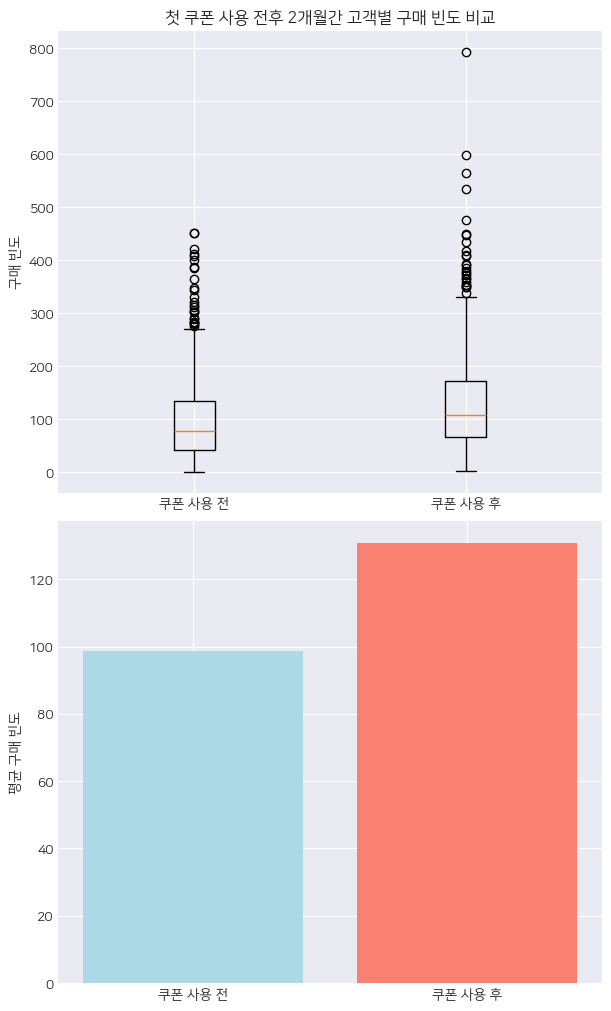

In [34]:
## 3) 시각화
# 평균 구매 빈도 계산
pre_avg_cnt = purchase_cnt_df['pre_purchase_cnt'].mean()
post_avg_cnt = purchase_cnt_df['post_purchase_cnt'].mean()

print(f'할인 쿠폰 사용 전 평균 구매빈도: {pre_avg_cnt}')
print(f'할인 쿠폰 사용 후 평균 구매빈도: {post_avg_cnt}')
print('\n------------------------------\n')

# 서브플롯 생성 (박스플롯 + 막대그래프)
fig, axes = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

# 1. 박스플롯
_ = axes[0].boxplot(
    [purchase_cnt_df['pre_purchase_cnt'], purchase_cnt_df['post_purchase_cnt']],
    labels=['쿠폰 사용 전', '쿠폰 사용 후']
)
_ = axes[0].set_title("첫 쿠폰 사용 전후 2개월간 고객별 구매 빈도 비교")
_ = axes[0].set_ylabel("구매 빈도")

# 2. 막대그래프
_ = axes[1].bar(['쿠폰 사용 전', '쿠폰 사용 후'], [pre_avg_cnt, post_avg_cnt], color=['lightblue', 'salmon'])
_ = axes[1].set_title("")
_ = axes[1].set_ylabel("평균 구매 빈도")

# 그래프 표시
plt.show()